# CRISPR-RNA-Editing Model Training and Evaluation
Harsh D. <br/>
Updated on 10/19/20
#### Notebook to train models based on the sequence and the edit rates contained in the metadata for each sample in the .fasta file. Can also create temporary .npz files for faster loading so the edit rates and sequences don't need to be extracted every time.
temp files stored in tmp/ directory

In [1]:
import os
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, utils


os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0" 

tp = "ABE" #"CBE" for cytidine deaminase base editor; "ABE" for adenine deaminase base editor
DATA_DIR = "crispr/data/Dataset/" #"Path to .fasta files"

In [2]:
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
from tqdm import tqdm
from multiprocessing import Pool
def seq_to_onehot(seq): 
    seq = seq.strip()
    values = list(seq+"ACTG") 
    label_encoder = LabelEncoder();
    integer_encoded = label_encoder.fit_transform(values);
    onehot_encoder = OneHotEncoder(sparse=False);
    integer_encoded = integer_encoded.reshape(len(integer_encoded), 1);
    onehot_encoded = onehot_encoder.fit_transform(integer_encoded); 
    return onehot_encoded[:-4] 
def editdata(line):
    data = line.split("_")
    return float(data[3])
def getData(chromosome):
    start = time.time()
    out = list()
    inp = list()
    with open(DATA_DIR+'{}.chr{}.fasta'.format(exp, chromosome),'rt') as f:
        for line in tqdm(f):
            if line[0:1] == ">":
                y = editdata(line)
                out.append(y)
            else:
                x = seq_to_onehot(line)
                assert x.shape[1] == 4
                inp.append(x)
    print(time.time()-start)
    X = np.stack(inp)
    Y = np.stack(out)
    print(Y.shape[0])
    Y = Y.reshape(Y.shape[0], 1)
    np.savez_compressed("tmp/{}.chr{}".format(exp, chromosome),x = X, y = Y)
def load_data(chromosomes):
    start = time.time()
    num_workers = len(chromosomes)
    with Pool(processes=num_workers) as pool:
        res = pool.map(getData, chromosomes)
    print(time.time()-start) 

#### You should prob. run it the first time with rebuild and rebuildTst set to true to generate the temp files but then set them to false to skip the process for later runs. If you get a file not found, you have not generated the temp file yet.

In [3]:
import time

rebuild = False # Whether or not to rebuild training temp files or just use the ones already generated
rebuildTst = False # Whether or not to rebuild testing temp files or just use the ones already generated

test_set = ["20", "21", "22", "X"] # The chromosomes that will be used for testing the model's performance
train_set = [str(x) for x in range(1, 20)] # The chromosomes that will be used for training the model.
val_set = test_set
print(train_set)
print(val_set)
print(test_set)

Xtr = list()
Ytr = list()

train = ["156B"] # The experiment from which the the training chromosomes will be taken
validation = ["157B"] # The experiment from which the the validation chromosomes will be taken
test = ["158B"] # The experiment from which the testing chromosomes will be taken
 
for experiment in train:
    exp = experiment
    if rebuild is True:
        load_data(train_set)
    for x in train_set:
        lmn = np.load("tmp/{}.chr{}.npz".format(exp, x))
        Xtr.append(lmn['x'])
        Ytr.append(lmn['y'])

X_train = np.concatenate(Xtr, axis=0)
Y_train = np.concatenate(Ytr, axis=0)
print("TOT: {}".format(X_train.shape[0]))

Xval = list()
Yval = list()

for experiment in validation:
    exp = experiment
    if rebuild is True:
        load_data(val_set)
    for x in val_set:
        lmn = np.load("tmp/{}.chr{}.npz".format(exp, x))
        Xval.append(lmn['x'])
        Yval.append(lmn['y'])
        
X_val = np.concatenate(Xval, axis=0)
Y_val = np.concatenate(Yval, axis=0)
print("TOT: {}".format(X_val.shape[0]))    

X_tst = list()
Y_tst = list()
for experiment in test:
    exp = experiment
    if rebuildTst is True:
        load_data(test_set)
    for x in test_set:
            lmn = np.load("tmp/{}.chr{}.npz".format(exp, x))
            X_tst.append(lmn['x'])
            Y_tst.append(lmn['y'])
X_test = np.concatenate(X_tst, axis=0)
Y_test = np.concatenate(Y_tst, axis=0)


['1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '12', '13', '14', '15', '16', '17', '18', '19']
['20', '21', '22', 'X']
['20', '21', '22', 'X']
TOT: 1945651
TOT: 183217


The "\_dz" variables were supposed to have only non-zero edit rate sequences and values but this was scrapped and the whole dataset is being used. This is the reason for the seemingly useless name change

In [4]:
X_train_dz = X_train
Y_train_dz = Y_train
print(X_train_dz.shape)
print(Y_train_dz.shape)
X_val_dz = X_val
Y_val_dz = Y_val
print(X_val_dz.shape)
print(Y_val_dz.shape)
X_test_dz = X_test
Y_test_dz = Y_test
print(X_test_dz.shape)
print(Y_test_dz.shape)

(1945651, 1001, 4)
(1945651, 1)
(183217, 1001, 4)
(183217, 1)
(166671, 1001, 4)
(166671, 1)


#### A simple data generator to give reversed sequences

In [5]:
import math
from tensorflow import keras
class SeqDataGenerator(keras.utils.Sequence):
    def __init__(self, x_set, y_set, batch_size):
        self.x, self.y = x_set, y_set
        self.dim = x_set.shape[1]
        self.batch_size = batch_size
        self.indexes = np.arange(len(self.x))
        
    def __len__(self):
        return math.ceil(len(self.x) / self.batch_size)
    
    def __on_epoch_end__(self):
        np.random.shuffle(self.indexes)
        
    def __getitem__(self, index):
        X = np.empty((2*self.batch_size, self.dim, 4))
        Y = np.empty((2*self.batch_size))
        for i, ID in enumerate(self.indexes[self.batch_size*index:min((self.batch_size)*(index+1), len(self.x))]):
                X[i,] = self.x[ID]
                X[self.batch_size+i,] = np.flipud(self.x[ID])
                Y[i] = self.y[ID]
                Y[self.batch_size+i,] = self.y[ID]
        return (X, Y)
        

#### Sets up the model architecture.

In [21]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, activations, Model, backend
from tensorflow.keras.layers import Input, Conv1D, ReLU, BatchNormalization,\
                                    Add, Activation, MaxPooling1D, Flatten, Dense, Dropout
import tensorflow.keras.backend as K
K.clear_session()

n = 500
def build_model():
    model = keras.Sequential(
        [
        layers.Input(shape=(2*n+1,4)),
        layers.Conv1D(128, 16, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1D(128, 8, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool1D(2, padding='same'),
        layers.Conv1D(64, 12, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPool1D(2, padding='same'),
        layers.Conv1D(64, 8, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Conv1D(64, 8, padding='same', activation='relu'),
        layers.MaxPool1D(4, padding='same'),
        layers.Flatten(),
        layers.Dense(32, activation='relu'),
        layers.BatchNormalization(),
        layers.Dense(1, activation='sigmoid'),
        ]
    )
    optimizer = tf.keras.optimizers.RMSprop(lr=0.01)
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model
def build_reg_model():
    model = keras.Sequential(
        [
        layers.Input(shape=(2*n+1,4)),
        layers.Flatten(),
        layers.Dense(1024, activation='relu'),
        layers.Dense(256, activation='relu'),
        layers.Dense(64, activation='relu'),
        layers.Dense(1, activation='sigmoid'),
        ]
    )
    optimizer = tf.keras.optimizers.RMSprop()
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model
def rb(x, n, w, dout):  
    y = Conv1D(n, w, padding='same')(x)
    y = layers.BatchNormalization()(y)
    y = Activation('relu')(y)
    y = Dropout(dout)(y)
    out = Add()([x, y])
    return out
def resnet():
    dout = 0.1
    lsr = 32
    lsr2 = 64
    lsr3 = 64
    inputs = keras.Input(shape=(2*n+1, 4))
    x = Conv1D(lsr, 1, padding='same')(inputs)
    x = rb(x, lsr, 3, dout)
    x = rb(x, lsr, 3, dout)
    x = rb(x, lsr, 3, dout)
    x = MaxPooling1D(4, padding = 'same')(x)
    x = Conv1D(lsr2, 1, padding='same')(x)
    x = rb(x, lsr2, 7, dout)
    x = rb(x, lsr2, 7, dout)
    x = MaxPooling1D(4, padding = 'same')(x)
    x = Conv1D(lsr3, 1, padding='same')(x)
    x = rb(x, lsr3, 7, dout)
    x = MaxPooling1D(4, padding = 'same')(x)
    x = Flatten()(x)
    x = Dense(lsr, activation='relu')(x)
    x = BatchNormalization()(x)
    output = Dense(1, activation='sigmoid')(x)
    model = Model(inputs, output)
    optimizer = tf.keras.optimizers.RMSprop()
    model.compile(loss="mse",
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

def build_func_model():
    dout = 0.1
    model = keras.Sequential(
        [
        layers.Input(shape=(2*n+1,4)),
        layers.Conv1D(48, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.Conv1D(64, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),  
        layers.Conv1D(100, 3, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),  
        layers.MaxPooling1D(2, padding='same'),
        layers.Conv1D(150, 7, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.Conv1D(300, 7, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.MaxPooling1D(3, padding='same'),
        layers.Conv1D(200, 7, padding='same', activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.MaxPooling1D(4, padding='same'),
        layers.Flatten(),
        layers.Dense(100, activation='relu'),
        layers.BatchNormalization(),
        layers.Dropout(dout),
        layers.Dense(1, activation='sigmoid'),
        ]
    )
    optimizer = tf.keras.optimizers.Adam()
    model.compile(loss='mse',
                optimizer=optimizer,
                metrics=['mae', 'mse'])
    return model

In [25]:
model = build_model()
model.summary()

tp = "ABE"
now = str(int(time.time()))

checkpoint_filepath = 'models/conv_net_{}-{}.h5'.format(tp, now)
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)

batch_size = 1024
sdg = SeqDataGenerator(X_train_dz[:,500-n:501+n,:], Y_train_dz, batch_size)
es = tf.keras.callbacks.EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
history = model.fit(x=sdg, epochs=20, validation_data=(X_val_dz[:,500-n:501+n,:], Y_val_dz), callbacks=[model_checkpoint_callback, es])

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_15 (Conv1D)           (None, 1001, 128)         8320      
_________________________________________________________________
batch_normalization_15 (Batc (None, 1001, 128)         512       
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 1001, 128)         131200    
_________________________________________________________________
batch_normalization_16 (Batc (None, 1001, 128)         512       
_________________________________________________________________
max_pooling1d_9 (MaxPooling1 (None, 501, 128)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 501, 64)           98368     
_________________________________________________________________
batch_normalization_17 (Batc (None, 501, 64)          

1901/1901 [==============================] - 1259s 662ms/step - loss: 9.1777e-04 - mean_absolute_error: 0.0142 - mean_squared_error: 9.1777e-04 - val_loss: 0.0010 - val_mean_absolute_error: 0.0138 - val_mean_squared_error: 0.0010
Epoch 3/20
  91/1901 [>.............................] - ETA: 19:41 - loss: 8.4208e-04 - mean_absolute_error: 0.0134 - mean_squared_error: 8.4208e-04

KeyboardInterrupt: 

In [34]:
checkpoint_filepath = "crispr/models/validation/ABE-1601230308.h5"

model = tf.keras.models.load_model(checkpoint_filepath)
model.summary()

print(checkpoint_filepath)

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 1001, 48)          624       
_________________________________________________________________
batch_normalization (BatchNo (None, 1001, 48)          192       
_________________________________________________________________
dropout (Dropout)            (None, 1001, 48)          0         
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 1001, 64)          9280      
_________________________________________________________________
batch_normalization_1 (Batch (None, 1001, 64)          256       
_________________________________________________________________
dropout_1 (Dropout)          (None, 1001, 64)          0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 1001, 100)         1

In [35]:
Y_pred = model.predict(X_test_dz[:,500-n:501+n,:], batch_size = 512)

In [36]:
print(Y_pred.shape)
print(Y_test_dz.shape)

(166671, 1)
(166671, 1)


In [37]:
Y_test_dz = Y_test_dz.reshape(Y_test_dz.shape[0], 1)

In [38]:
from scipy import stats
def getSpearman(arr1, arr2):    
    return stats.spearmanr(arr1.astype("float64"), arr2.astype("float64"))
import scipy
print("Spearman Coeff:\t"+str(getSpearman(Y_pred, Y_test_dz)[0]))
print("Pearson Coeff:\t"+str(scipy.stats.pearsonr(Y_pred.flatten(), Y_test_dz.flatten())[0]))

Spearman Coeff:	0.36228485495703194
Pearson Coeff:	0.5154214236573327


In [42]:
from scipy.stats import kde
import matplotlib.pyplot as plt
nbins=100
x = Y_pred.flatten()
y = Y_test_dz.flatten()
k = kde.gaussian_kde([x,y])
xi, yi = np.mgrid[x.min():x.max():nbins*1j, y.min():y.max():nbins*1j]
zi = k(np.vstack([xi.flatten(), yi.flatten()]))

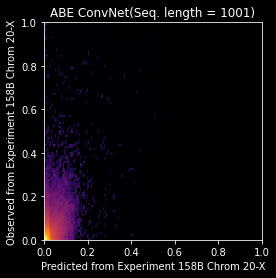

Spearman Coeff:	0.36228485495703194
Pearson Coeff:	0.5154214236573327


In [43]:
from matplotlib import colors
import matplotlib
plt.style.use(['dark_background'])
exp = "158B Chrom 20-X"
plt.axis('square')
plt.ylabel("Observed from Experiment {}".format(exp))
plt.xlabel("Predicted from Experiment {}".format(exp))
plt.title("ABE ConvNet(Seq. length = 1001)")
plt.xlim(0,1)
plt.ylim(0,1)
plt.pcolormesh(xi, yi, zi.reshape(xi.shape),cmap=plt.cm.inferno, norm=matplotlib.colors.LogNorm(vmin=1e-2), snap=False)
plt.show()
import scipy
print("Spearman Coeff:\t"+str(getSpearman(Y_pred, Y_test_dz)[0]))
print("Pearson Coeff:\t"+str(scipy.stats.pearsonr(Y_pred.flatten(), Y_test_dz.flatten())[0]))